In [1]:
# import libraries
import numpy as np

import torch
import torch.nn as nn
import torch.nn.functional as F

import copy

import matplotlib.pyplot as plt
from IPython import display
display.set_matplotlib_formats('svg')

/tmp/ipykernel_988/2850606974.py:12: DeprecationWarning: `set_matplotlib_formats` is deprecated since IPython 7.23, directly use `matplotlib_inline.backend_inline.set_matplotlib_formats()`
  display.set_matplotlib_formats('svg')


# Import and process the data

In [2]:
data = np.loadtxt(open('train_mnist.csv','rb'),delimiter=',',skiprows=1)

# don't need labels!
data = data[:,1:]

# normalize the data to a range of [0 1]
dataNorm = data / np.max(data)

# convert to tensor
dataT = torch.tensor( dataNorm ).float()

# Demonstration of implementing occlusion

- **Image Selection and Occlusion**: The code selects a specific image from the preprocessed dataset by its index (2134) and views it as a 28x28 matrix representing the original MNIST image. It then creates an occluded version of this image by setting the pixel values of rows 10 to 13 to the maximum value (1), simulating an occlusion in the image.

- **Visualization Setup**: A figure with two subplots is prepared to display both the original and the occluded images side by side for comparison.

- **Image Display**: The original image is displayed in the first subplot, and the occluded image is shown in the second subplot. Both subplots use a grayscale color map, have titles indicating their content, and do not display axis ticks or labels to focus on the visual comparison.

- **Presentation of Results**: The generated plot provides a visual representation of the effect of occlusion on an image from the MNIST dataset, illustrating the challenge of recognizing occluded digits, which can be a relevant task for testing the robustness of machine learning models, especially autoencoders designed for denoising or reconstruction tasks.


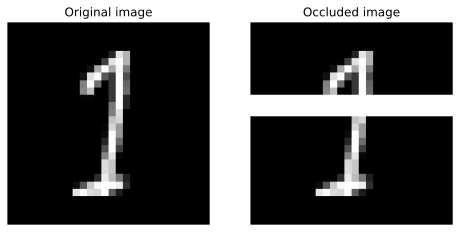

In [3]:
# reconstruct a sample as an image

img = dataT[2134,:].view(28,28)


occluded = copy.deepcopy( img )
occluded[10:13,:] = 1

fig,ax = plt.subplots(1,2,figsize=(8,5))

ax[0].imshow(img,cmap='gray')
ax[0].set_title('Original image')
ax[0].axis('off')

ax[1].imshow(occluded,cmap='gray')
ax[1].set_title('Occluded image')
ax[1].axis('off')

plt.show()

# Create the DL model

In [4]:
# create a class for the model
def createTheMNISTAE():

  class aenet(nn.Module):
    def __init__(self):
      super().__init__()

      ### input layer
      self.input = nn.Linear(784,128)
      
      ### encoder layer
      self.enc = nn.Linear(128,50)

      ### latent layer
      self.lat = nn.Linear(50,128)

      ### decoder layer
      self.dec = nn.Linear(128,784)

    # forward pass
    def forward(self,x):
      x = F.relu( self.input(x) )
      x = F.relu( self.enc(x) )
      x = F.relu( self.lat(x) )
      y = torch.sigmoid( self.dec(x) )
      return y
  
  # create the model instance
  net = aenet()
  
  # loss function
  lossfun = nn.MSELoss()

  # optimizer
  optimizer = torch.optim.Adam(net.parameters(),lr=.001)

  return net,lossfun,optimizer

# Create a function that trains the model

In [5]:
def function2trainTheModel():

  # number of epochs
  numepochs = 5
  
  # create a new model
  net,lossfun,optimizer = createTheMNISTAE()

  # initialize losses
  losses = []



  # batch size and number of batches
  batchsize  = 32
  numBatches = int(dataT.shape[0]/batchsize)


  # loop over epochs (now each epoch goes through all samples)
  for epochi in range(numepochs):

    
    # get a permuted index vector
    randidx = np.random.permutation(dataT.shape[0]).astype(int)
    
    for batchi in range(numBatches):
      
      # samples to use in this batch
      samps2use = range((batchi-1)*batchsize,batchi*batchsize)
      

      # select those images
      X = dataT[randidx[samps2use],:]

      # forward pass and loss
      yHat = net(X)
      loss = lossfun(yHat,X)

      # backprop
      optimizer.zero_grad()
      loss.backward()
      optimizer.step()

    
      # losses in this batch
      losses.append( loss.item() )

  # end epochs
  
  # function output
  return losses,net

# Run the model and show the results!

Final loss: 0.0082


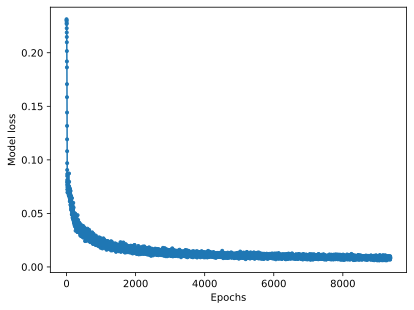

In [6]:
# train the model (16s)
losses,net = function2trainTheModel()
print(f'Final loss: {losses[-1]:.4f}')

# visualize the losses
plt.plot(losses,'.-')
plt.xlabel('Epochs')
plt.ylabel('Model loss')
plt.show()

# Add occlusion to some images

- **Image Preprocessing and Occlusion**: A set of 10 images from the preprocessed MNIST dataset (`dataT`) is selected for experimentation. Each image is individually processed to add occlusions; for even-indexed images, a horizontal line is occluded, while for odd-indexed images, a vertical line is occluded. This is achieved by setting the pixel values in the selected rows or columns to 1, simulating occlusion.

- **Model Inference on Occluded Images**: The occluded images are then passed through the pretrained model (`net`) to attempt de-occlusion or reconstruction, producing a set of de-occluded images. This step tests the model's ability to recover original digit shapes despite the presence of occlusions.

- **Visualization of Results**: Three rows of images are displayed in a figure:
  - The first row shows the original images from the dataset before occlusion.
  - The second row displays the images after occlusion has been added, highlighting the intervention.
  - The third row presents the de-occluded images as reconstructed by the model, allowing for a visual assessment of the model's performance in handling occluded data.

- **Observational Insights**: This experiment visually demonstrates the model's capacity to interpret and reconstruct images that have been artificially impaired. It showcases the potential of neural networks in tasks that require understanding and processing of visual data, even when it is incomplete or obscured.


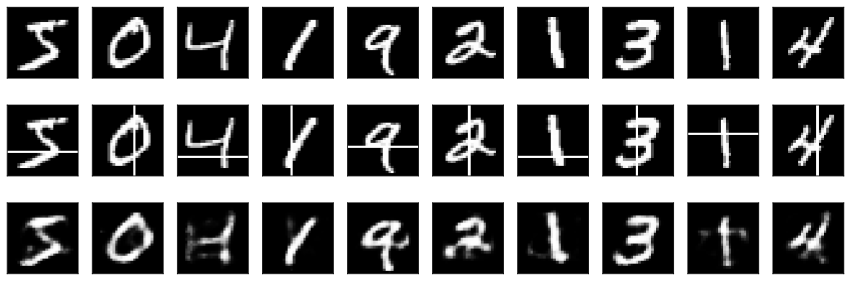

In [7]:
# grab a small set of images
X = copy.deepcopy( dataT[:10,:] )

# add noise
for i in range(X.shape[0]):
  
  # reshape the image
  img = X[i,:].view(28,28)

  # occlude random rows or columns
  startloc = np.random.choice(range(10,21))
  if i%2==0: # even -> horizontal occlusion
    img[startloc:startloc+1,:] = 1
  else:      # odd -> vertical occlusion
    img[:,startloc:startloc+1] = 1



# run the samples through the model
deOccluded = net(X)


# show the noisy images
fig,axs = plt.subplots(3,10,figsize=(15,5))

for i in range(10):
  axs[0,i].imshow(dataT[i,:].view(28,28).detach() ,cmap='gray')
  axs[1,i].imshow(X[i,:].view(28,28).detach() ,cmap='gray')
  axs[2,i].imshow(deOccluded[i,:].view(28,28).detach() ,cmap='gray')
  axs[0,i].set_xticks([]), axs[0,i].set_yticks([])
  axs[1,i].set_xticks([]), axs[1,i].set_yticks([])
  axs[2,i].set_xticks([]), axs[2,i].set_yticks([])
  
plt.show()

# Something more quantitative

- **Performance Evaluation via Correlation**: The code quantifies the performance of the model's ability to reconstruct or "de-occlude" images by calculating the correlation coefficient between the original and reconstructed pixel values of a sample image. This provides a numerical measure of the similarity between the original image (before occlusion) and the model's reconstructed output.

- **Visualization of Original vs. Reconstructed Values**: A scatter plot is generated to visually compare the original pixel values of the selected image against the reconstructed pixel values. Each point represents a pixel, with its position along the x-axis indicating its original value and its position along the y-axis showing its value after reconstruction by the model.

- **Correlation Coefficient Display**: The plot includes a title that presents the correlation coefficient (`r`) calculated between the original and reconstructed pixel values. This coefficient ranges from -1 to 1, where 1 indicates perfect correlation, 0 indicates no linear correlation, and -1 indicates perfect inverse correlation. The closer the coefficient is to 1, the more effectively the model has reconstructed the original image from the occluded version.

- **Insight on Model's De-Occlusion Capability**: By displaying the correlation coefficient, the plot offers a concise summary of how well the model can recover the original appearance of an occluded image. A high correlation coefficient suggests that the model can accurately reconstruct occluded images, highlighting its potential utility in applications where recovering or interpreting occluded or incomplete visual information is necessary.


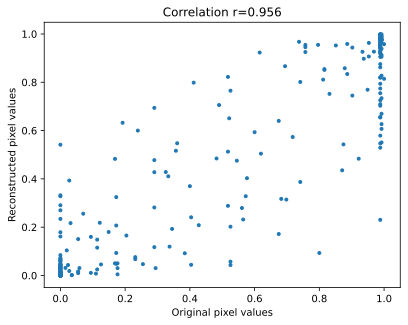

In [8]:
recon_random_samp = 7

inOutCorr = np.corrcoef(dataT[recon_random_samp,:].detach(),deOccluded[recon_random_samp,:].detach())

# and plot
plt.plot(dataT[recon_random_samp,:].detach(),deOccluded[recon_random_samp,:].detach(),'.')
plt.xlabel('Original pixel values')
plt.ylabel('Reconstructed pixel values')
plt.title(f'Correlation r={ inOutCorr[0,1] :.3f}')
plt.show()

- **Refined Performance Evaluation**: The script refines the performance evaluation of the model's de-occlusion capability by focusing on non-zero-valued pixels. This approach aims to exclude background pixels, which are typically zero-valued in MNIST images, to concentrate on the parts of the image that contain actual digit information. A tolerance threshold (`tol`) is set to identify non-zero pixels, allowing for minor deviations due to floating-point arithmetic.

- **Correlation Calculation on Meaningful Pixels**: By applying a boolean mask (`nonzeropixels`) that identifies pixels with values greater than a specified tolerance in both the original and reconstructed images, the correlation coefficient is recalculated. This method ensures that the evaluation considers only the pixels that contribute to the visual content of the digits, potentially providing a more accurate measure of the model's effectiveness in reconstructing occluded or corrupted parts of an image.

- **Visualization Adjustments**: A scatter plot is again used to compare the original and reconstructed pixel values, but this time it includes only the meaningful (non-zero) pixels. This visualization helps to highlight the model's performance on the core parts of the image, excluding the background.

- **Enhanced Insight on Model Performance**: Displaying the correlation coefficient calculated from non-zero pixels offers a focused assessment of the model's reconstruction accuracy. A high correlation in this context indicates the model's proficiency in capturing and reproducing the essential features of the digit, ignoring the less informative background areas. This method provides a nuanced understanding of the model's capabilities, emphasizing its effectiveness in contexts where precision in the digit or feature reconstruction is critical.


In [9]:
# try again without the zero-valued pixels

# extract to variables for convenience
orig  = dataT[recon_random_samp,:].detach()
recon = deOccluded[recon_random_samp,:].detach()

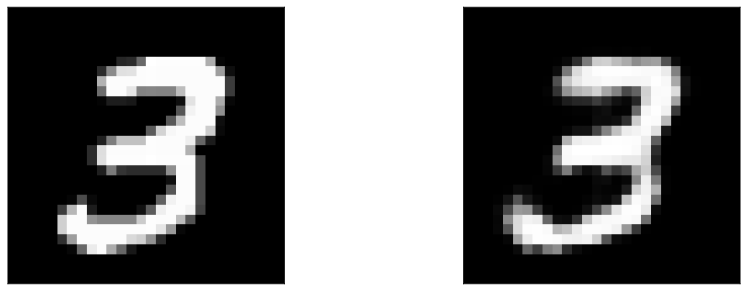

In [10]:
# show the noisy images
fig,(axs1, axs2) = plt.subplots(1,2,figsize=(15,5))

axs1.imshow(orig.view(28, 28),cmap='gray')
axs1.set_xticks([]), axs1.set_yticks([])

axs2.imshow(recon.view(28, 28),cmap='gray')
axs2.set_xticks([]), axs2.set_yticks([])
  
plt.show()

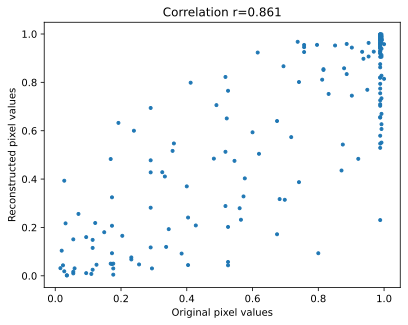

In [11]:
# boolean vector that indicates pixels>0 (with some tolerance)
tol = 1e-4
nonzeropixels = (orig>tol) & (recon>tol)

# then re-compute the correlation
inOutCorr = np.corrcoef(orig[nonzeropixels],recon[nonzeropixels])

# redraw the previous plot
plt.plot(orig[nonzeropixels],recon[nonzeropixels],'.')
plt.xlabel('Original pixel values')
plt.ylabel('Reconstructed pixel values')
plt.title(f'Correlation r={ inOutCorr[0,1] :.3f}')
plt.show()

In [12]:
nonzeropixels

tensor([False, False, False, False, False, False, False, False, False, False,
        False, False, False, False, False, False, False, False, False, False,
        False, False, False, False, False, False, False, False, False, False,
        False, False, False, False, False, False, False, False, False, False,
        False, False, False, False, False, False, False, False, False, False,
        False, False, False, False, False, False, False, False, False, False,
        False, False, False, False, False, False, False, False, False, False,
        False, False, False, False, False, False, False, False, False, False,
        False, False, False, False, False, False, False, False, False, False,
        False, False, False, False, False, False, False, False, False, False,
        False, False, False, False, False, False, False, False, False, False,
        False, False, False, False, False, False, False, False, False, False,
        False, False, False, False, False, False, False, False, 

- **Refined Performance Analysis**: This segment of code advances the evaluation of the model's de-occlusion capabilities by considering two scenarios: the model's output on non-occluded (original) images (`noOcclusion`) and its performance on occluded images (`deOccluded`). The aim is to compare how the presence of occlusion affects the model's ability to reconstruct images that are close to their original state.

- **Focused Comparison on Non-zero Pixels**: By incorporating a tolerance threshold (`tol`), the analysis narrows down to non-zero pixels in the original dataset, excluding background pixels that contribute less to the overall accuracy assessment of meaningful image content. This approach aims to ensure that the comparison focuses on the pixels that are most significant to the visual content of the images.

- **Correlation Coefficient Calculation**: For each of the first ten samples, correlation coefficients are calculated between the original images and both the non-occluded and the occluded reconstructed images. This results in a set of correlation values indicating how well the model can replicate the original image detail in both scenarios.

- **Visual Representation of Comparative Performance**: A scatter plot displays the correlation coefficients for each sample, distinguishing between the scenarios with and without occlusion. This visual comparison elucidates the impact of occlusion on the model's reconstruction accuracy, as indicated by how closely the reconstructed images correlate with their original counterparts.

The approach provides insights into the effectiveness of the autoencoder model in handling occluded versus non-occluded images, offering a nuanced understanding of its performance in different contexts.


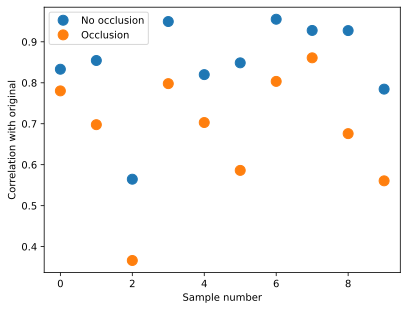

In [13]:
# get data with no occlusion
noOcclusion = net(dataT[:10,:])

# compare deOccluded-original to noOcclusion-original correlation
r = np.zeros((10,2))
for i in range(deOccluded.shape[0]):

  # pixel selection (note: tolerance defined in previous cell)
  nonzeropixels = (dataT[i,:]>tol) & (noOcclusion[i,:]>tol) & (deOccluded[i,:]>tol)

  # now compute the correlations
  r[i,0] = np.corrcoef(dataT[i,nonzeropixels].detach(),noOcclusion[i,nonzeropixels].detach())[0,1]
  r[i,1] = np.corrcoef(dataT[i,nonzeropixels].detach(),deOccluded[i,nonzeropixels].detach())[0,1]


# plot the correlation coefficients
plt.plot(r,'o',markersize=10)
plt.legend(['No occlusion','Occlusion'])
plt.xlabel('Sample number')
plt.ylabel('Correlation with original')
plt.show()

In [14]:
import torch
import numpy as np
import matplotlib.pyplot as plt
from copy import deepcopy

def test_occlusion_proportions(net, dataT, n_samples=10, n_proportions=20, max_proportion=0.9):
    """
    Test network reconstruction performance across different occlusion proportions up to 90%.
    
    Args:
        net: The trained autoencoder network
        dataT: The test dataset
        n_samples: Number of samples to test for each proportion
        n_proportions: Number of different proportions to test
        max_proportion: Maximum proportion of image to occlude (0.9 = 90%)
    
    Returns:
        proportions: List of tested proportions
        losses_h: Losses for horizontal occlusions
        losses_v: Losses for vertical occlusions
    """
    # Define the proportions to test (from 1 pixel to max_proportion of the image)
    proportions = np.linspace(1/28, max_proportion, n_proportions)
    
    # Initialize arrays to store losses
    losses_h = np.zeros((n_proportions, n_samples))
    losses_v = np.zeros((n_proportions, n_samples))
    
    criterion = torch.nn.MSELoss()
    
    # Test each proportion
    for p_idx, prop in enumerate(proportions):
        # Calculate occlusion width in pixels
        width = max(1, int(28 * prop))
        
        # Test multiple samples
        for s_idx in range(n_samples):
            # Get a random image
            X = deepcopy(dataT[s_idx:s_idx+1, :])
            orig_img = deepcopy(X)
            
            # Create horizontal occlusion
            img_h = X[0,:].view(28,28)
            # Adjust starting location range based on occlusion width
            max_start = max(0, 28 - width)
            startloc = np.random.randint(0, max_start + 1) if max_start > 0 else 0
            img_h[startloc:min(startloc+width, 28),:] = 1
            
            # Create vertical occlusion
            img_v = deepcopy(X[0,:].view(28,28))
            startloc = np.random.randint(0, max_start + 1) if max_start > 0 else 0
            img_v[:,startloc:min(startloc+width, 28)] = 1
            
            # Get reconstructions
            with torch.no_grad():
                recon_h = net(X)
                X[0,:] = img_v.flatten()
                recon_v = net(X)
            
            # Calculate losses
            losses_h[p_idx, s_idx] = criterion(recon_h, orig_img).item()
            losses_v[p_idx, s_idx] = criterion(recon_v, orig_img).item()
    
    return proportions, losses_h, losses_v

def plot_occlusion_results(proportions, losses_h, losses_v):
    """
    Plot the results of occlusion analysis with enhanced visualization for large proportions.
    """
    plt.figure(figsize=(12, 7))
    
    # Calculate mean and std of losses
    mean_h = np.mean(losses_h, axis=1)
    std_h = np.std(losses_h, axis=1)
    mean_v = np.mean(losses_v, axis=1)
    std_v = np.std(losses_v, axis=1)
    
    # Plot means with error bands
    plt.plot(proportions * 100, mean_h, 'b-', label='Horizontal Occlusion', linewidth=2)
    plt.fill_between(proportions * 100, mean_h - std_h, mean_h + std_h, 
                     color='b', alpha=0.2)
    
    plt.plot(proportions * 100, mean_v, 'r-', label='Vertical Occlusion', linewidth=2)
    plt.fill_between(proportions * 100, mean_v - std_v, mean_v + std_v,
                     color='r', alpha=0.2)
    
    # Add vertical lines at key percentages
    key_percentages = [25, 50, 75]
    for pct in key_percentages:
        plt.axvline(x=pct, color='gray', linestyle='--', alpha=0.3)
        plt.text(pct+1, plt.ylim()[0], f'{pct}%', 
                rotation=0, verticalalignment='bottom')
    
    plt.xlabel('Occlusion Proportion (%)')
    plt.ylabel('Reconstruction Loss')
    plt.title('Network Performance vs. Occlusion Proportion (up to 90%)')
    plt.legend()
    plt.grid(True)
    
    # Add secondary axis showing approximate pixels occluded
    ax2 = plt.gca().secondary_xaxis('top', 
        functions=(lambda x: x*0.28, lambda x: x/0.28))
    ax2.set_xlabel('Approximate Pixels Occluded')
    
    return plt.gcf()

# Example usage:
# proportions, losses_h, losses_v = test_occlusion_proportions(net, dataT, max_proportion=0.9)
# plot_occlusion_results(proportions, losses_h, losses_v)
# plt.show()

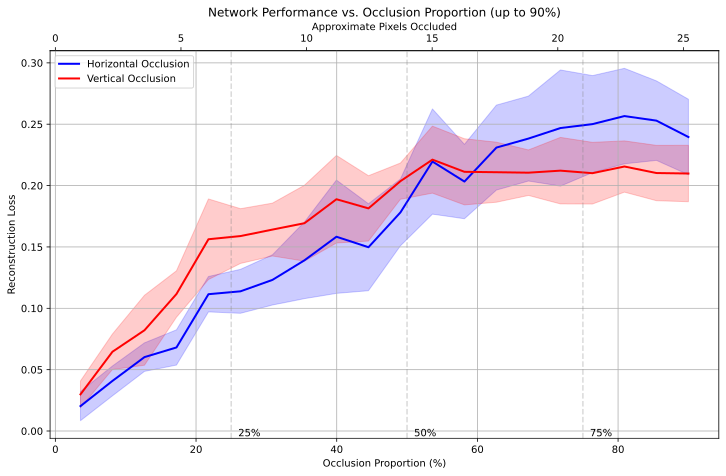

In [15]:
# Run the analysis
proportions, losses_h, losses_v = test_occlusion_proportions(net, dataT, 
                                                           max_proportion=0.9)
# Create and show the plot
plot_occlusion_results(proportions, losses_h, losses_v)
plt.show()